In [19]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV

import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import arch
import math
import statistics
#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [20]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("Gasoil") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel



<AxesSubplot:xlabel='Timestamp'>

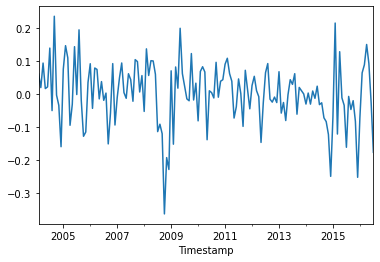

In [21]:
og = df1["LGOc1"]
spot = df1["LGOc1"]
spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30'].diff().dropna()
spot_train = spot.loc[:'2016-07-31']
spot_train.plot()

In [22]:
### original series

spotog = og.loc['2004-01-31':'2022-11-30'].dropna()
trainog, testog = model_selection.train_test_split(spotog, train_size=((spot_train.shape[0])+1))

In [23]:
### realized vol ###

diff_series = og.loc['2004-01-31':'2022-11-30'].diff().dropna()
traindiff, testdiff = model_selection.train_test_split(diff_series, train_size=((spot_train.shape[0])))
realized_vol = testdiff**2
realized_vol


Timestamp
2016-08-31     1870.5625
2016-09-30     1040.0625
2016-10-31       42.2500
2016-11-30       64.0000
2016-12-31     2782.5625
                 ...    
2022-07-31     2862.2500
2022-08-31       64.0000
2022-09-30    11077.5625
2022-10-31    11449.0000
2022-11-30    29929.0000
Name: LGOc1, Length: 76, dtype: float64

In [24]:
# Load the data and split it into separate pieces
#data = np.array(spot.dropna())**2
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

In [25]:
garch = arch.arch_model(train,mean='Zero', vol='ARCH', p=2, rescale=False)
#garch = arch.arch_model(train, vol='GARCH', p=1, q=1)
results = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -32.7210643966214
Iteration:      2,   Func. Count:     12,   Neg. LLF: -124.22468243648798
Iteration:      3,   Func. Count:     17,   Neg. LLF: -148.01501379742382
Iteration:      4,   Func. Count:     22,   Neg. LLF: -148.38894205592538
Iteration:      5,   Func. Count:     27,   Neg. LLF: -148.41214131742402
Iteration:      6,   Func. Count:     31,   Neg. LLF: -148.41267572706778
Iteration:      7,   Func. Count:     35,   Neg. LLF: -148.41269694108217
Iteration:      8,   Func. Count:     38,   Neg. LLF: -148.41269694112884
Optimization terminated successfully    (Exit mode 0)
            Current function value: -148.41269694108217
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8


In [26]:
print(results.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.007
Vol Model:                       ARCH   Log-Likelihood:                148.413
Distribution:                  Normal   AIC:                          -290.825
Method:            Maximum Likelihood   BIC:                          -281.793
                                        No. Observations:                  150
Date:                Tue, Nov 07 2023   Df Residuals:                      150
Time:                        20:00:09   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.8603e-03  1.156e-03      5.070  3.978e-07 [3.

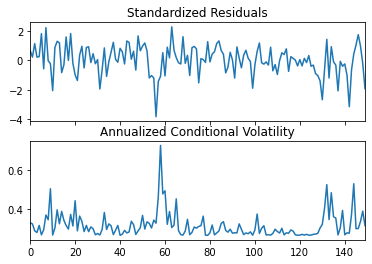

In [27]:
# Plot the standardized residuals
fig = results.plot(annualize='M')
#fig = results.plot()
plt.show()

In [28]:
yhat = results.forecast(horizon=1)
#np.exp(yhat.variance.values)
#math.sqrt(yhat.variance.values.flatten())
#math.sqrt(yhat.variance.values.flatten()[0])
#np.exp(yhat.variance.values.flatten()[0])
yhat.variance.values.flatten()[0]

0.007886840132883616

In [29]:
# Generate statistics and diagnostic plots

#a= results.conditional_volatility
#plt.plot(a)

In [30]:
#### One-step-ahead predictions of volatility ###

predicted_returns = []

for i in range(len(test)):
    insample_data = data[i:-(len(test)-i)]
    
    garch = arch.arch_model(insample_data,mean='Zero', vol='ARCH', p=2, rescale=False)
    #garch = arch.arch_model(train, vol='GARCH', p=1, q=1)
    results = garch.fit(disp='off')

    yhat = results.forecast(horizon=1)
    log_std = math.sqrt(yhat.variance.values.flatten()[0])

    const_std = np.exp(log_std)
    predicted_returns.append(const_std)


test_shift3 = list(testog)
test_shift3.insert(0, trainog[-1])
test_shift3.pop()

predicted_std_price = list((test_shift3 * np.array(predicted_returns)) - test_shift3)

predicted_vol = pd.DataFrame(predicted_std_price)**2
predicted_std_price


[34.47823899518397,
 54.06926465902433,
 45.47683404317428,
 39.31428471931969,
 35.448023159113006,
 43.56329872066124,
 48.84511666080232,
 38.459251876488565,
 36.79380214943035,
 35.607137323028894,
 33.56117858788366,
 32.13166975755064,
 43.98133664087243,
 47.15062030118861,
 45.300088290681856,
 46.17113897524928,
 40.1899528709763,
 48.59801183829143,
 47.57808984948599,
 44.80671363563056,
 51.91001147465204,
 53.300037510278685,
 52.71365735185782,
 48.40900793875062,
 46.643112645034876,
 52.501642667783244,
 55.30947135089764,
 50.62597874327935,
 81.64471853107796,
 66.6231171317445,
 59.230492216071184,
 61.732691546615,
 48.49306883018323,
 50.445679509974184,
 52.568986806685075,
 50.64549215207671,
 45.017924957676314,
 45.66891544877046,
 48.58394150877098,
 44.63841570482987,
 43.02040360240801,
 49.985976719973905,
 66.33108011956585,
 56.26550887439839,
 76.19314202766549,
 65.77889384386373,
 48.12426210672203,
 61.36885572005019,
 51.34033195749055,
 27.12742160

In [31]:
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))*100

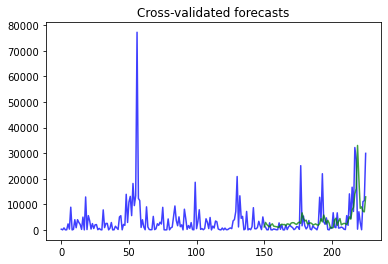

In [32]:
exp_predictions = np.array(predicted_vol)
exp_spot= diff_series**2
exp_test = np.array(realized_vol)
exp_train = traindiff**2

#exp_predictions = np.sqrt(exp_predictions)
#exp_spot= np.sqrt(exp_spot)
#exp_test = np.sqrt(exp_test)
#exp_train = np.sqrt(exp_train)

x_axis = np.arange(exp_spot.shape[0])
n_test = exp_predictions.shape[0]

plt.plot(x_axis, exp_spot, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], exp_predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [33]:
error = mean_squared_error(exp_test, exp_predictions)
print('Mean Squared Error: %.3f' % error)
error2 = mean_absolute_error(exp_test, exp_predictions)
print('Mean Absolute Error: %.3f' % error2)
error3 = mean_absolute_percentage_error(exp_test, exp_predictions)
print('Mean Absolute Percentage Error: %.3f' % (error3*100))
error4 = smape_kun(exp_test, exp_predictions)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error4)

Mean Squared Error: 46992651.336
Mean Absolute Error: 3975.783
Mean Absolute Percentage Error: 1915.919
Symmetric Mean Absolute Percentage Error: 117.704


In [34]:
### same with built-in function ###

#predictions22 = model_selection.cross_val_score(
#    ar, spot, scoring='mean_absolute_error', cv=cv, verbose=0)
#np.average(predictions22)

In [35]:
#### MASE ###

abs_errors = abs(exp_predictions - exp_test)
mae_naive_list = []

for x in range(len(exp_test)):
    insample_data = exp_spot[x:-(len(exp_test)-x)]
    mae_insample = np.mean(abs(insample_data.diff().dropna()))
    mae_naive_list.append(mae_insample)

mase = np.mean(abs_errors / mae_naive_list)

print('Mean Absolute Scaled Error: %.3f' % mase)

Mean Absolute Scaled Error: 1.310


In [36]:
### Merton test ###

test_app = list(exp_test)
test_app.insert(0, exp_train[-1]) ## append last of train data
dir = np.array(np.sign(pd.DataFrame(test_app).diff().dropna()))

pred_app = list(exp_predictions)

test_shift = list(exp_test)
test_shift.insert(0, exp_train[-1])
test_shift.pop()

dir_pred = np.array(np.sign([a - b for a, b in zip(pred_app,test_shift)]))

q_minus = 0
q_plus = 0
pred_minus = 0
pred_plus = 0

for t in range(len(dir)):
    if dir[t] == 1:
        q_plus += 1
        if dir_pred[t] == 1:
            pred_plus += 1
    if dir[t] == -1:
        q_minus += 1
        if dir_pred[t] == -1:
            pred_minus += 1

print('Merton test: %.3f' % ((pred_plus / q_plus) + (pred_minus / q_minus)))

Merton test: 1.322
